In [3]:
import os
import numpy as np
from tensorflow import keras
from keras import layers
import csv
import tensorflow as tf

2023-05-11 17:13:54.300338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
#the path to images
path_to_images = 'Data/dataset1/known_images'

In [43]:
# Training and validating the dataset
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    path_to_images,
    class_names = ['Normal','Sick'],
    batch_size = 16,
    image_size = (395, 488),
    validation_split = 0.2,
    subset = "both",
    seed = 200
)

Found 715 files belonging to 2 classes.
Using 572 files for training.
Using 143 files for validation.


In [44]:
#Instantiating and freezing the VGG19 Convolutional base
conv_base = keras.applications.VGG19(
    weights = 'imagenet',
    include_top = False,
)

conv_base.trainable = False

In [45]:
#data augumentation
data_augmentation = keras.Sequential(

    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2)
    ]
)


In [46]:
inputs = keras.Input(shape = (395, 488, 3))
X = data_augmentation(inputs)

X = keras.applications.vgg19.preprocess_input(X)
X = conv_base(X)
X = layers.Flatten()(X)
X = layers.Dense(256)(X)
X = layers.Dropout (0.5)(X)

outputs = layers.Dense(1, activation = 'sigmoid')(X)
model = keras.Model(inputs,outputs)


In [47]:
#Compiling the model

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [48]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'Chest_opacities_detection_model_using_transfer_learning.keras',
        save_best_only = True,
        monitor = 'val_loss'

    )
]

In [49]:

history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = val_dataset,
    callbacks = callbacks
)

Epoch 1/30
36/36 [==============================] - 4779s 136s/step - loss: 74.8436 - accuracy: 0.7867 - val_loss: 1.8816 - val_accuracy: 0.9371
Epoch 2/30
36/36 [==============================] - 866s 23s/step - loss: 17.6425 - accuracy: 0.8951 - val_loss: 3.1580 - val_accuracy: 0.9580
Epoch 3/30
36/36 [==============================] - 1076s 30s/step - loss: 15.7156 - accuracy: 0.9196 - val_loss: 35.7719 - val_accuracy: 0.7762
Epoch 4/30
36/36 [==============================] - 1471s 41s/step - loss: 15.2939 - accuracy: 0.9161 - val_loss: 2.4444 - val_accuracy: 0.9720
Epoch 5/30
36/36 [==============================] - 1348s 38s/step - loss: 6.0379 - accuracy: 0.9528 - val_loss: 2.6626 - val_accuracy: 0.9580
Epoch 6/30
36/36 [==============================] - 1782s 50s/step - loss: 9.6784 - accuracy: 0.9493 - val_loss: 8.1123 - val_accuracy: 0.9371
Epoch 7/30
36/36 [==============================] - 2014s 57s/step - loss: 7.9315 - accuracy: 0.9633 - val_loss: 3.1121 - val_accuracy: 0

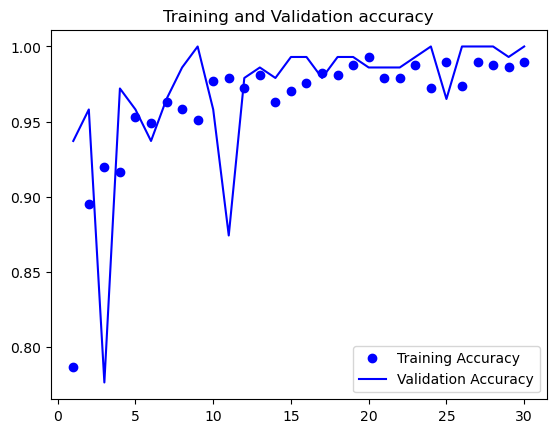

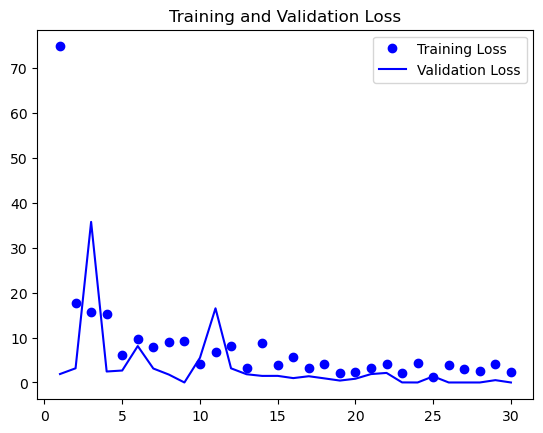

<Figure size 640x480 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt
accuracy = history.history ['accuracy']
val_accuracy = history.history ['val_accuracy']
loss = history.history ['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

#Accuracy plots
plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

#Loss plots
plt.plot(epochs, loss,'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()
plt.show()


In [24]:
#trainable and non-trainable parameters
model = keras.models.load_model('Chest_opacities_detection_model_using_transfer_learning.keras')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 395, 488, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 395, 488, 3)       0         
                                                                 
 tf.__operators__.getitem_6   (None, 395, 488, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 395, 488, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_4 (Flatten)         (None, 92160)             0   

In [29]:
#defining directory containing the test images
test_dir = "./Data/dataset1/unknown_images"

#getting the list of test image file paths
test_image_paths = [os.path.join(test_dir,f) for f in os.listdir(test_dir)]

In [41]:
#Creating an empty array to store the predicted labels
predicted_with_filenames = []

#looping through each test image, make prediction and store the predicated label
for image_path in test_image_paths:
    #loading the image and resizing it to the target size
    img = keras.preprocessing.image.load_img(image_path, target_size = (395,488))

    #converting the image to a numpy array
    img_array = keras.preprocessing.image.img_to_array(img)

    #Preprocessing
    img_array = keras.applications.vgg19.preprocess_input(img_array)

    #Expanding the dimensions of the array to create batch axis
    img_array = np.expand_dims(img_array, 0)

    #Making predictions on the image
    predictions = model.predict(img_array,0)

    #convert the predictions to a binary label(1 for Normal, 0 for Sick)
    predicted_labels = int(predictions[0]>0.5)

    #Extracting the file name from the image path
    file_name = os.path.basename(image_path)

    #adding the predicted label and file name to the list
    predicted_with_filenames.append((file_name, predicted_labels))

1/1 [==============================] - 1s 1s/step


In [50]:
#saving the predictions with file name as CSV file
with open('Dorothy_Ankunda_2200701759_chest_opacities_model_using_transfer_learning.csv','w',newline = '') as csvfile:
    writer = csv.writer(csvfile)

    #Adding my name , Registration Number and Student Number to the file
    writer.writerow(['Name', 'Dorothy Ankunda'])
    writer.writerow(['Student Number', '2200701759'])
    writer.writerow(['Registration Number', '2022/HD05/1759U'])
    writer.writerow(['  ', '  '])
    writer.writerow(['File Name', 'Prediction Name'])
    for predictions in predicted_with_filenames:
        writer.writerow(predictions)

In [7]:
path_to_dataset_2 = 'Data/dataset2/images'

In [8]:
# Training and validating the dataset
test_dataset = keras.utils.image_dataset_from_directory(
    path_to_dataset_2,
    class_names = ['Normal','Sick'],
    batch_size = 32,
    image_size = (395, 488),

)

Found 224 files belonging to 2 classes.


In [9]:
test_model = keras.models.load_model("Chest_opacities_detection_model_using_transfer_learning.keras")

In [10]:
test_loss, test_accuracy = test_model.evaluate(test_dataset)


7/7 [==============================] - 254s 37s/step - loss: 487.7845 - accuracy: 0.4509


In [11]:
print(f"Test Accuracy: {test_accuracy:3f} and Test loss: {test_loss:3f}")

Test Accuracy: 0.450893 and Test loss: 487.784485
